In [22]:
from read_alignment import readAlignment
import helperFxns_new as kim_helper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
import seaborn as sns


In [23]:
def rewrite_header_fasta(input_fasta, output_fasta):
    with open(output_fasta, "w") as out_f:
        for i, record in enumerate(SeqIO.parse(input_fasta, "fasta"), start=1):
            record.id = f"seq{i}"
            record.description = ""  # Remove any additional description
            SeqIO.write(record, out_f, "fasta")

    print("Headers updated successfully!")



def clean_fasta(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        fasta_dict = {}
        header = None
        for line in infile:
            line = line.strip()  # Remove leading/trailing whitespace (including erroneous newlines)
            if line.startswith(">"):  # New header
                header = line
                fasta_dict[header] = []
            elif header:  # Sequence line
                fasta_dict[header].append(line)

        # Write cleaned FASTA
        for header, seq_list in fasta_dict.items():
            outfile.write(f"{header}\n{''.join(seq_list)}\n")  # Concatenated sequence in one line

def compute_avg_seq_identity(smat):
    num_sequences = smat.shape[0]

    # Compute the average pairwise identity for each sequence
    # sum up each row (i.e. along the columns), subtract from self-comparison, divide by total # of sequences
    avg_identity = (smat.sum(axis=1) - np.diag(smat)) / (num_sequences - 1)

    return avg_identity


def plot_avg_seq_identity_histogram(smat, bins=50):
    """ Given a sequence identity matrix, plot a histogram of the average pairwise sequence identity for each sequence. """
    num_sequences = smat.shape[0]

    # Compute the average pairwise identity for each sequence
    # sum up each row (i.e. along the columns), subtract from self-comparison, divide by total # of sequences
    avg_identity = (smat.sum(axis=1) - np.diag(smat)) / (num_sequences - 1)

    # Plot histogram
    plt.figure(figsize=(8,6))
    plt.hist(avg_identity, bins=bins, density=True, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel("Average Pairwise Sequence Identity")
    plt.ylabel("Density")
    plt.title("Histogram of Average Pairwise Sequence Identity")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()


In [24]:
# clean_fasta("data/sythetic_serotonin_aligned.fa", "data/cleaned_synthetic_serotonin_aligned.fasta")

# rewrite_header_fasta(input_fasta="data/synthetic_sequences.txt", output_fasta="data/renamed_synthetic_sequences.txt")

# natural sequences

In [25]:
arr_seq = readAlignment('data/cleaned_serotonin_aligned.fasta')
print('len of sequences:', len(arr_seq))

# arr_seq = readAlignment('data/renamed_synthetic_sequences.txt')
# print('len of sequences:', len(arr_seq))


len of sequences: 970


In [26]:
# convert from array of string seq to numeric
arr_num = kim_helper.lett2num(arr_seq, code='ACDEFGHIKLMNPQRSTVWY-')
print('arr_num shape:', arr_num.shape)
arr_num


arr_num shape: (970, 2767)


array([[21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21],
       ...,
       [21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21]])

In [27]:
# convert to one-hot encoding
# not needed as we need to further filter
one_hot = kim_helper.alg2bin(arr_num)
one_hot

<970x58107 sparse matrix of type '<class 'numpy.float64'>'
	with 2683926 stored elements in Compressed Sparse Row format>

In [28]:
hd = np.arange(0, len(arr_num))
print('seq shape before filtering:', arr_num.shape)
hFilt, seqFilt = kim_helper.filterAln(hd, arr_num)
print('seq shape after filtering:', seqFilt.shape)

seq shape before filtering: (970, 2767)
seq shape after filtering: (752, 437)


In [29]:
# compute the one-hot encoding again
one_hot_filtered = kim_helper.alg2bin(seqFilt)
print('one hot after filtering:', one_hot_filtered.shape)

# compute the sequence identity matrix
n_align_pos = seqFilt.shape[1] # seqFilt.shape = (num_seq, num_positions)
identity_real = kim_helper.simMat(one_hot_filtered, n_align_pos)
print('identity shape:', identity_real.shape)

one hot after filtering: (752, 9177)
identity shape: (752, 752)


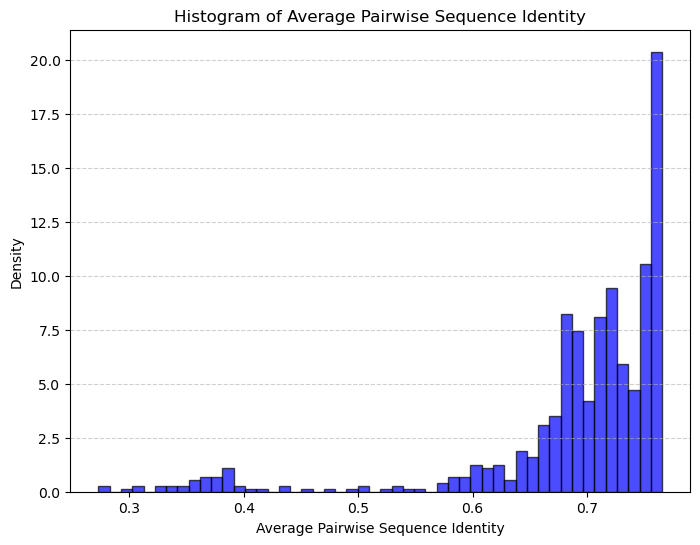

In [30]:
plot_avg_seq_identity_histogram(identity_real)

# artificial sequences

In [31]:
arr_seq = readAlignment('data/cleaned_synthetic_serotonin_aligned.fasta')
print('len of sequences:', len(arr_seq))

# convert from array of string seq to numeric
arr_num = kim_helper.lett2num(arr_seq, code='ACDEFGHIKLMNPQRSTVWY-')
print('arr_num shape:', arr_num.shape)

len of sequences: 100
arr_num shape: (100, 399)


In [32]:
hd = np.arange(0, len(arr_num))
print('seq shape before filtering:', arr_num.shape)
hFilt, seqFilt = kim_helper.filterAln(hd, arr_num)
print('seq shape after filtering:', seqFilt.shape)

seq shape before filtering: (100, 399)
seq shape after filtering: (100, 389)


In [33]:
# compute the one-hot encoding again
one_hot_filtered = kim_helper.alg2bin(seqFilt)
print('one hot after filtering:', one_hot_filtered.shape)

# compute the sequence identity matrix
n_align_pos = seqFilt.shape[1] # seqFilt.shape = (num_seq, num_positions)
identity_mpnn = kim_helper.simMat(one_hot_filtered, n_align_pos)
print('identity shape:', identity_mpnn.shape)

one hot after filtering: (100, 8169)
identity shape: (100, 100)


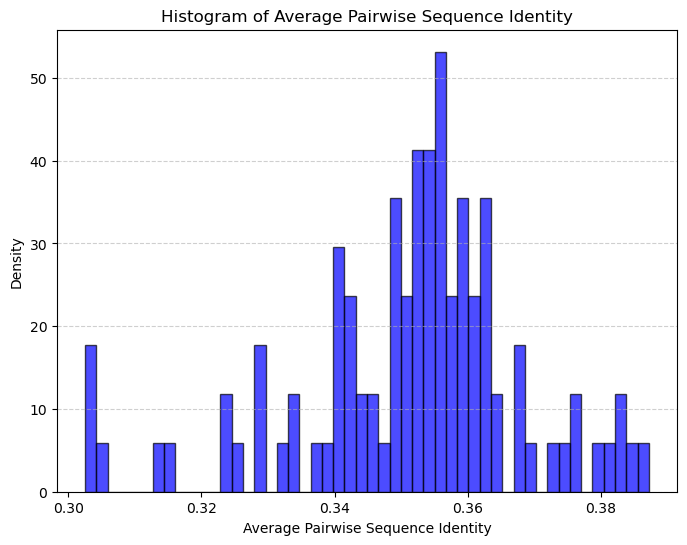

In [34]:
plot_avg_seq_identity_histogram(identity_mpnn)

In [35]:
artificial_ident = compute_avg_seq_identity(identity_mpnn)
real_ident = compute_avg_seq_identity(identity_real)


Text(0.5, 1.0, 'KDE Plot of Sequence Identity Distributions')

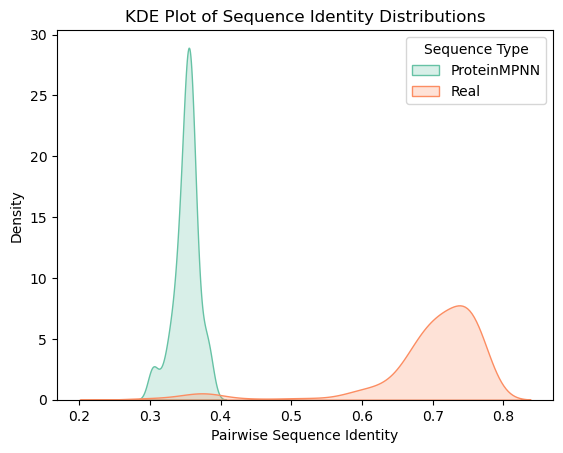

In [41]:
# Example usage with artificial and real sequence identities
sns.kdeplot(artificial_ident, fill=True, color=sns.color_palette("Set2")[0], label="ProteinMPNN")
sns.kdeplot(real_ident, fill=True, color=sns.color_palette("Set2")[1], label="Real")

# Add legend
plt.legend(title="Sequence Type")

# Optional: Add labels and title
plt.xlabel("Pairwise Sequence Identity")
plt.ylabel("Density")
plt.title("KDE Plot of Sequence Identity Distributions")

# plt.savefig()